##### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.simplefilter(action="ignore")

##### Read in the data and visualize it 

In [2]:
sales = pd.read_csv("TOTALSA.csv", parse_dates=['DATE']).rename(columns={'TOTALSA': 'Sales'})

GDP = pd.read_csv("GDP.csv", parse_dates=['DATE']).assign(GDP = lambda cols: cols['GDP']/1000)

GDP

,DATE,GDP
0,2017-04-01,19.304506
1,2017-07-01,19.561896
2,2017-10-01,19.894750
3,2018-01-01,20.155486
4,2018-04-01,20.470197
5,2018-07-01,20.687278
6,2018-10-01,20.819269
7,2019-01-01,21.013085
8,2019-04-01,21.272448
9,2019-07-01,21.531839


In [3]:
sales

,DATE,Sales
0,2017-09-01,18.318
1,2017-10-01,18.484
2,2017-11-01,17.995
3,2017-12-01,17.903
4,2018-01-01,17.508
...,...,...
56,2022-05-01,13.044
57,2022-06-01,13.523
58,2022-07-01,13.756
59,2022-08-01,13.621


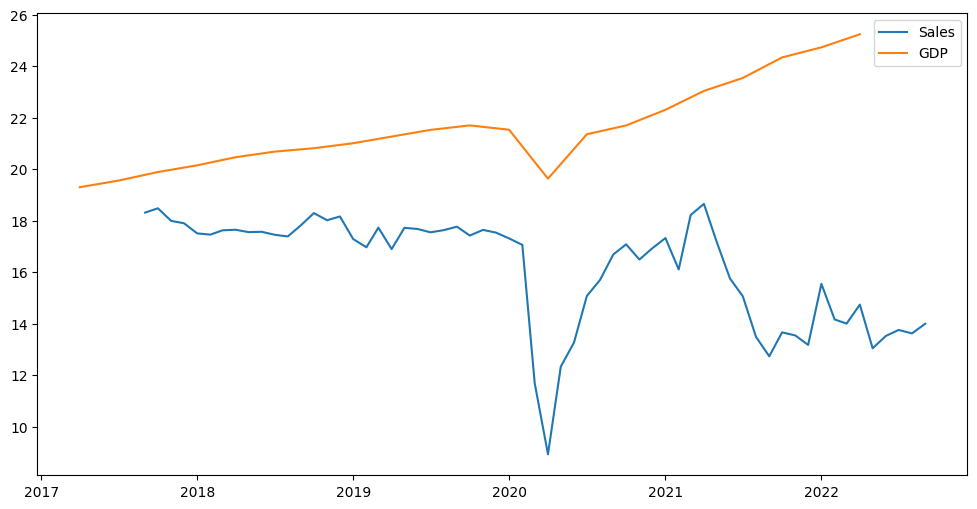

In [4]:
plt.figure(figsize=(12,6))
plt.plot(sales['DATE'], sales['Sales'], label='Sales')
plt.plot(GDP['DATE'], GDP['GDP'], label='GDP')
plt.legend()
plt.show()

##### Get sales and GDP on the same time grain and impute missing values

In [5]:
GDP = GDP.assign(DATE = lambda cols: cols['DATE'] + pd.Timedelta(32, 'D')).assign(DATE = lambda cols: cols['DATE'].apply(lambda x: x.replace(day=1)))

In [6]:
GDP

,DATE,GDP
0,2017-05-01,19.304506
1,2017-08-01,19.561896
2,2017-11-01,19.894750
3,2018-02-01,20.155486
4,2018-05-01,20.470197
5,2018-08-01,20.687278
6,2018-11-01,20.819269
7,2019-02-01,21.013085
8,2019-05-01,21.272448
9,2019-08-01,21.531839


In [7]:
df = pd.merge(
    left = sales,
    right = GDP,
    on = "DATE",
    how = "outer"
).sort_values(by = 'DATE', ascending=True)
df

,DATE,Sales,GDP
0,2017-05-01,NaN,19.304506
1,2017-08-01,NaN,19.561896
2,2017-09-01,18.318,NaN
3,2017-10-01,18.484,NaN
4,2017-11-01,17.995,19.894750
...,...,...,...
58,2022-05-01,13.044,25.248476
59,2022-06-01,13.523,NaN
60,2022-07-01,13.756,NaN
61,2022-08-01,13.621,NaN


In [8]:
df.tail(15)

,DATE,Sales,GDP
48,2021-07-01,15.067,NaN
49,2021-08-01,13.486,23.550420
50,2021-09-01,12.731,NaN
51,2021-10-01,13.662,NaN
52,2021-11-01,13.542,24.349121
53,2021-12-01,13.173,NaN
54,2022-01-01,15.549,NaN
55,2022-02-01,14.164,24.740480
56,2022-03-01,14.003,NaN
57,2022-04-01,14.740,NaN


In [9]:
df['GDP'] = df['GDP'].interpolate(method='linear', limit_direction='backward')
df.tail(15)

,DATE,Sales,GDP
48,2021-07-01,15.067,23.382591
49,2021-08-01,13.486,23.550420
50,2021-09-01,12.731,23.816654
51,2021-10-01,13.662,24.082887
52,2021-11-01,13.542,24.349121
53,2021-12-01,13.173,24.479574
54,2022-01-01,15.549,24.610027
55,2022-02-01,14.164,24.740480
56,2022-03-01,14.003,24.909812
57,2022-04-01,14.740,25.079144


In [10]:
GDP_avg_growth_rate = (df['GDP'] / df['GDP'].shift(1)).dropna().tail(5).mean()
for i in range(df.shape[0]):
    if (pd.isnull(df.loc[i, 'GDP'])):
        df.loc[i, 'GDP'] = df.loc[i-1, 'GDP'] * GDP_avg_growth_rate

In [11]:
GDP

,DATE,GDP
0,2017-05-01,19.304506
1,2017-08-01,19.561896
2,2017-11-01,19.894750
3,2018-02-01,20.155486
4,2018-05-01,20.470197
5,2018-08-01,20.687278
6,2018-11-01,20.819269
7,2019-02-01,21.013085
8,2019-05-01,21.272448
9,2019-08-01,21.531839


In [12]:
df = df.dropna(axis=0, how='any').reset_index(drop=True)
df

,DATE,Sales,GDP
0,2017-09-01,18.318,19.672847
1,2017-10-01,18.484,19.783799
2,2017-11-01,17.995,19.894750
3,2017-12-01,17.903,19.981662
4,2018-01-01,17.508,20.068574
...,...,...,...
56,2022-05-01,13.044,25.248476
57,2022-06-01,13.523,25.405137
58,2022-07-01,13.756,25.562771
59,2022-08-01,13.621,25.721382


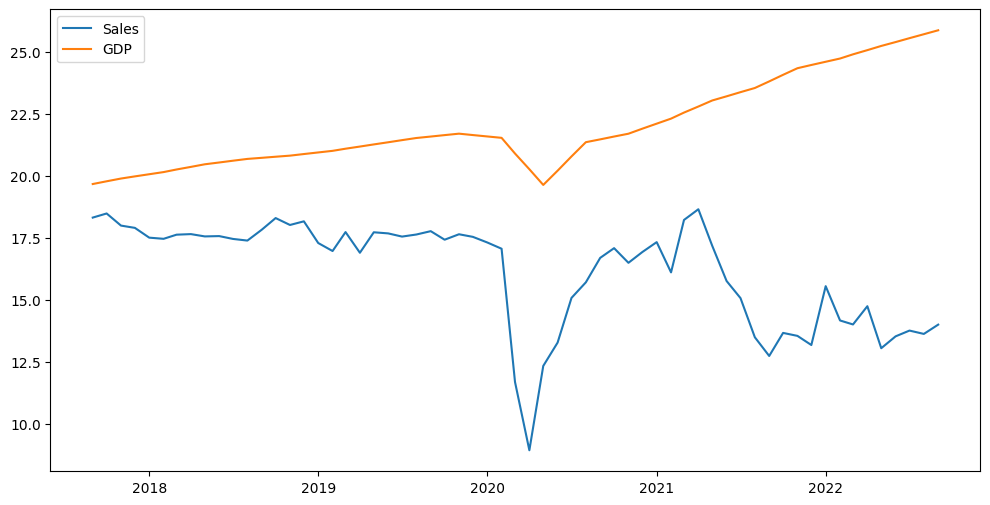

In [13]:
plt.figure(figsize=(12,6))
plt.plot(df['DATE'], df['Sales'], label='Sales')
plt.plot(df['DATE'], df['GDP'], label='GDP')
plt.legend()
plt.show()

##### Create training and test sets

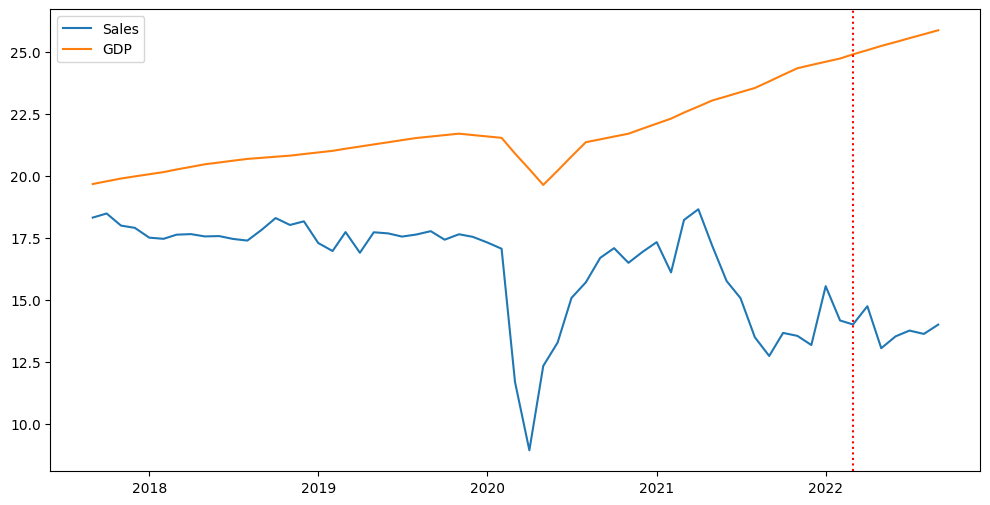

In [14]:
MAX_TRAINING_DATE = df.tail(7).iloc[0]['DATE']
plt.figure(figsize=(12,6))
plt.plot(df['DATE'], df['Sales'], label='Sales')
plt.plot(df['DATE'], df['GDP'], label='GDP')
plt.axvline(MAX_TRAINING_DATE, color='red', linestyle='dotted')
plt.legend()
plt.show()

In [15]:
df_train = df.loc[df['DATE'] < MAX_TRAINING_DATE, :]
df_test = df.loc[df['DATE'] >= MAX_TRAINING_DATE, :]

##### Build an initial model

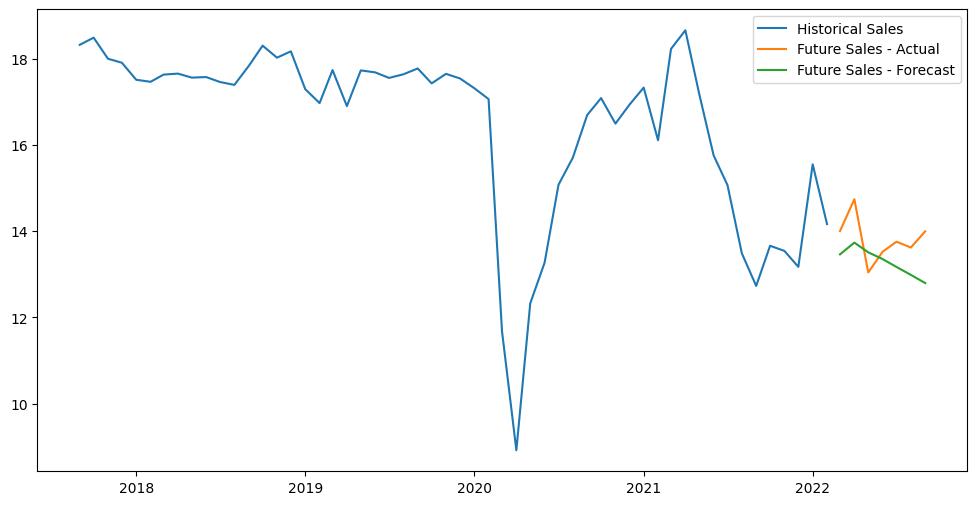

In [16]:
model = SARIMAX(
    endog = df_train['Sales'],
    exog = df_train['GDP'],
    order = (1,2,3), # p, d, q order parameters for arima
    trend = [1,0], # A(t) = a0 + a1 * t + a2*t^2 ...
    seasonal_order = (0,0,0,12) # P, D, Q  seasonal order parameters
).fit(disp=False)

forecast = model.forecast(steps=df_test.shape[0], exog = df_test['GDP'])

plt.figure(figsize=(12,6))
plt.plot(df_train['DATE'], df_train['Sales'], label='Historical Sales')
plt.plot(df_test['DATE'], df_test['Sales'], label='Future Sales - Actual')
plt.plot(df_test['DATE'], forecast, label='Future Sales - Forecast')
plt.legend()
plt.show()

##### Create hyperparameter scoring function and parameter search step function

In [17]:
# Function to 'step' randomly in hyperparameter space
def step(params):
    updated_params = deepcopy(params)
    selected_variable = np.random.choice(['p', 'd', 'q', 'P', 'D', 'Q', 'a0', 'a1'], size=1)[0]
    current_value = updated_params[selected_variable]
    
    # Update the current value randomly
    updated_value = current_value + np.random.choice([-1,1], size=1)[0]
    
    # Enforce parameter limits
    if (selected_variable in ['p', 'q']):
        low, high = 0,6
    else:
        low, high = 0,1
        
    updated_value = min([max([low, updated_value]), high])

    updated_params[selected_variable] = updated_value
    
    return updated_params

In [18]:
# Example 
x0 = {'p':1, 'd': 1, 'q': 0, 'p': 0, 'P': 0, 'D':0, 'Q':0, 'a0':1, 'a1':0}
print(x0)
for i in range(10):
    print(step(x0))

{'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}
{'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}
{'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 0, 'a0': 1, 'a1': 0}
{'p': 0, 'd': 1, 'q': 0, 'P': 1, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}
{'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}
{'p': 0, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}
{'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}
{'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}
{'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 0, 'a1': 0}
{'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}
{'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}


In [19]:
# function to score hyperparameter set
def score(params, data):

    error_scores = []
    
    for validation_steps in [1,2,3,4,5]:
        training_set_length = data.shape[0] - validation_steps
        
        model = SARIMAX(
            endog = df_train['Sales'].head(training_set_length),
            exog = df_train['GDP'].head(training_set_length),
            order = (params['p'], params['d'], params['q']), # p, d, q order parameters for arima
            trend = [params['a0'], params['a1']], # A(t) = a0 + a1 * t + a2*t^2 ...
            seasonal_order = (params['p'], params['D'], params['Q'], 12) # P, D, Q  seasonal order parameters
        ).fit(disp=False)
        forecast = model.forecast(steps=validation_steps, exog = data['GDP'].tail(validation_steps))
        actuals = data['Sales'].tail(validation_steps)
        # compute error metric and return 
        error = (forecast.tail(1) - actuals.tail(1)).abs().mean()
        error_scores.append(error)
    return np.mean(error_scores)

score(x0, df_train)

0.9018258103768492

##### Run hyperparameter optimization scan

In [25]:
# Initial guess
x0 = {'p':1, 'd': 1, 'q': 0, 'p': 0, 'P': 0, 'D':0, 'Q':0, 'a0':1, 'a1':1}
f0 = score(x0, df_train)

# keep track of best parameters
xbest = deepcopy(x0)
fbest = f0

print('initial parameter score = ', f0)

initial parameter score =  1.615781479419515


In [26]:
optimization_steps = 100

temperature = 0.05

optimization_progress = {'f0': [], 'fbest': []}

for t in range(optimization_steps):
    # Randomly changed x0
    x1 = step(x0)
    f1 = score(x1, df_train)

    # If the new point is lower than the previous (meaning better)
    if (f1 < f0):
        x0 = deepcopy(x1)
        f0 = f1
    else: # if new point is worse, accept with some probability
        if (np.random.random() < 2**(-(f1-f0)/temperature)): # similar to boltzman constant
            x0 = deepcopy(x1)
            f0 = f1

    # Update the 'best' parameters 
    if (f0 < fbest):
        fbest = f0
        xbest = deepcopy(x0)
    
    # print out progress
    print('current score = {}, best score={}'.format(f0, fbest))
    optimization_progress['f0'].append(f0)
    optimization_progress['fbest'].append(fbest)

current score = 1.6537477034366266, best score=1.615781479419515
current score = 1.6537477034366266, best score=1.615781479419515
current score = 1.6537477034366266, best score=1.615781479419515
current score = 1.6537477034366266, best score=1.615781479419515
current score = 1.6537477034366266, best score=1.615781479419515
current score = 1.6537477034366266, best score=1.615781479419515
current score = 1.6357841957991401, best score=1.615781479419515
current score = 1.6357841957991401, best score=1.615781479419515
current score = 1.6357841957991401, best score=1.615781479419515
current score = 1.3798332088261436, best score=1.3798332088261436
current score = 1.3798332088261436, best score=1.3798332088261436
current score = 1.313989005976575, best score=1.313989005976575
current score = 1.313989005976575, best score=1.313989005976575
current score = 1.313989005976575, best score=1.313989005976575
current score = 1.313989005976575, best score=1.313989005976575
current score = 1.313989005

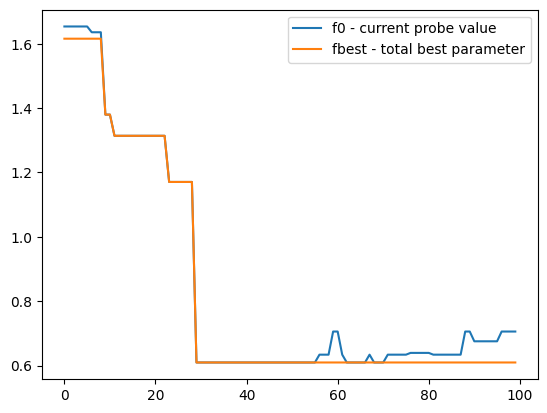

In [27]:
plt.figure()
plt.plot(optimization_progress['f0'], label='f0 - current probe value')
plt.plot(optimization_progress['fbest'], label='fbest - total best parameter')
plt.legend()
plt.show()

##### Select the best hyperparameters, refit to whole training set, and predict test set

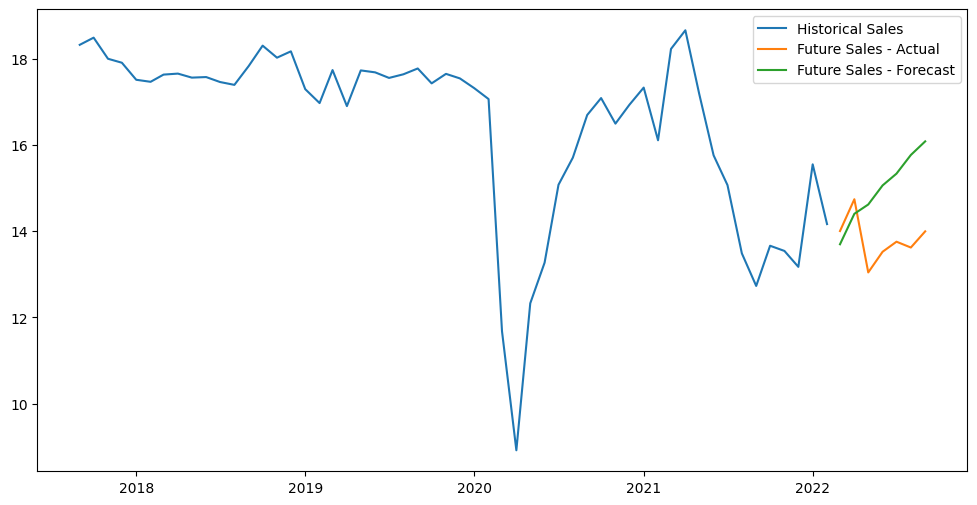

In [28]:
model = SARIMAX(
    endog = df_train['Sales'],
    exog = df_train['GDP'],
    order = (xbest['p'], xbest['d'], xbest['q']), # p, d, q order parameters for arima
    trend = [xbest['a0'], xbest['a1']], # A(t) = a0 + a1 * t + a2*t^2 ...
    seasonal_order = (xbest['P'], xbest['D'], xbest['Q'], 12) # P, D, Q  seasonal order parameters
).fit(disp=False)

forecast = model.forecast(steps=df_test.shape[0], exog = df_test['GDP'])

plt.figure(figsize=(12,6))
plt.plot(df_train['DATE'], df_train['Sales'], label='Historical Sales')
plt.plot(df_test['DATE'], df_test['Sales'], label='Future Sales - Actual')
plt.plot(df_test['DATE'], forecast, label='Future Sales - Forecast')
plt.legend()
plt.show()